#### Name : Janhavi Katre 
#### Roll No : 05

In [ ]:
import numpy as np
from keras.datasets import mnist
from keras.layers import Flatten, Reshape
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
def load_real_samples():
    # Load the MNIST dataset
    (X_train, _), (_, _) = mnist.load_data()

    # Normalize pixel values to the range [-1, 1]
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5

    # Reshape the data to a 1D array of size 784 (28x28)
    X_train = X_train.reshape(X_train.shape[0], 784)
    return X_train


In [ ]:
# Define the generator model
def define_generator(latent_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=latent_dim, activation='relu'))
    model.add(Dense(784, activation='tanh'))
    model.add(Reshape((28, 28)))
    return model

# Define the discriminator model
def define_discriminator():
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28)))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
# Define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
    # Make weights in the discriminator not trainable
    discriminator.trainable = False
    # Connect them
    model = Sequential()
    # Add generator
    model.add(generator)
    # Add the discriminator
    model.add(discriminator)
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model


In [ ]:
# Generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
    # Generate points in the latent space
    x_input = np.random.randn(latent_dim * n)
    # Reshape into a batch of inputs for the network
    x_input = x_input.reshape(n, latent_dim)
    return x_input

In [ ]:
# Generate n real samples
def generate_real_samples(dataset, n_samples):
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    X = X.reshape(n_samples, 28, 28)  # Reshape to (28, 28)
    y = np.ones((n_samples, 1))
    return X, y
# Generate n fake samples using the generator
def generate_fake_samples(generator, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = generator.predict(x_input)
    y = np.zeros((n_samples, 1))
    return X, y

In [ ]:
from matplotlib import pyplot as plt

# Helper function to plot a grid of images
def plot_images(images, title):
    n = int(np.sqrt(len(images)))
    fig, axes = plt.subplots(n, n, figsize=(8, 8))
    fig.subplots_adjust(hspace=0.3)
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.suptitle(title)
    plt.show()

# Evaluate the discriminator and plot real and fake MNIST images
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):
    # Prepare real samples
    x_real, y_real = generate_real_samples(dataset, n)
    # Evaluate discriminator on real examples
    _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)

    # Prepare fake examples
    x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
    # Evaluate discriminator on fake examples
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)

    # Summarize discriminator performance
    print(f"Epoch: {epoch+1}, Accuracy Real: {acc_real*100:.2f}%, Accuracy Fake: {acc_fake*100:.2f}%")

    # Display real and fake MNIST images
    if (epoch + 1) % 2000 == 0:
        plot_images(x_real[:10], title=f'Real MNIST Images (Epoch {epoch+1})')
        plot_images(x_fake[:10], title=f'Fake MNIST Images (Epoch {epoch+1})')


In [ ]:
def train(g_model, d_model, gan_model, latent_dim, dataset, n_epochs=10000, n_batch=128, n_eval=2000):
    half_batch = int(n_batch / 2)
    for i in range(n_epochs):
        x_real, y_real = generate_real_samples(dataset, half_batch)
        x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        d_model.train_on_batch(x_real, y_real)
        d_model.train_on_batch(x_fake, y_fake)

        x_gan = generate_latent_points(latent_dim, n_batch)
        y_gan = np.ones((n_batch, 1))
        gan_model.train_on_batch(x_gan, y_gan)

        if (i + 1) % n_eval == 0:
            summarize_performance(i, g_model, d_model, latent_dim)


4/4 [==============================] - 0s 4ms/step
Epoch: 2000, Accuracy Real: 100.00%, Accuracy Fake: 99.00%


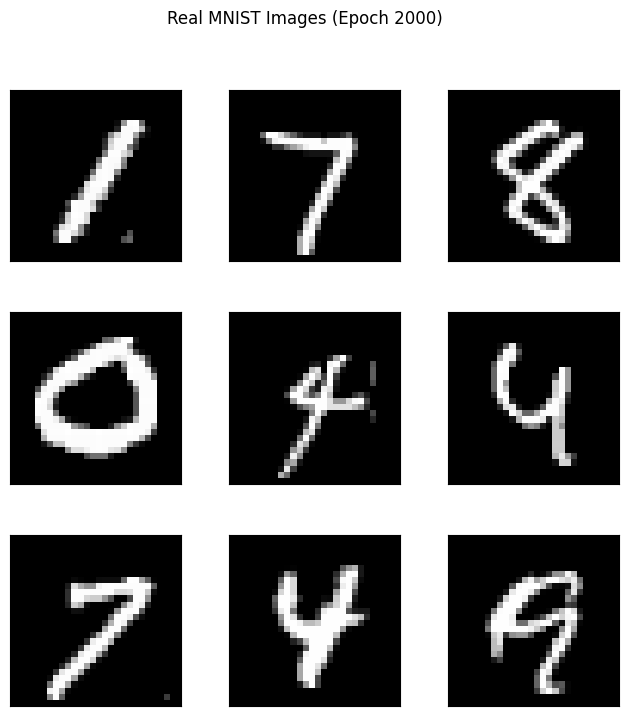

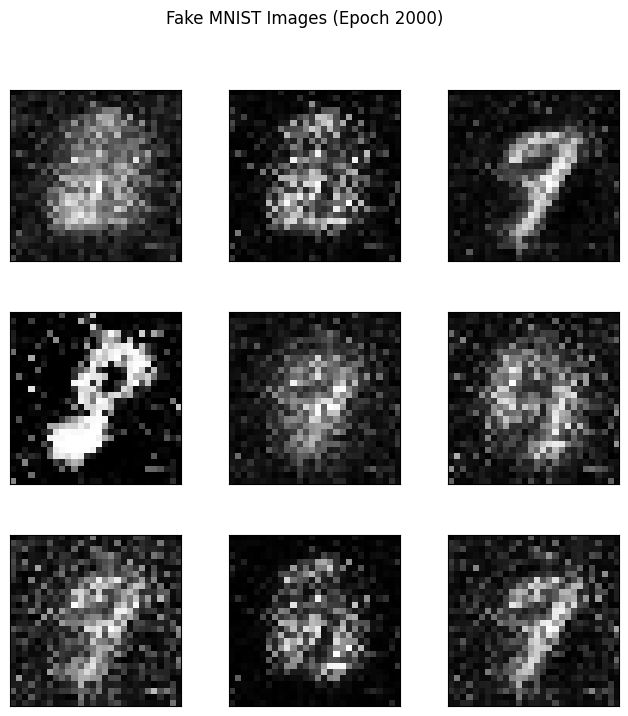

4/4 [==============================] - 0s 6ms/step
Epoch: 4000, Accuracy Real: 93.00%, Accuracy Fake: 97.00%


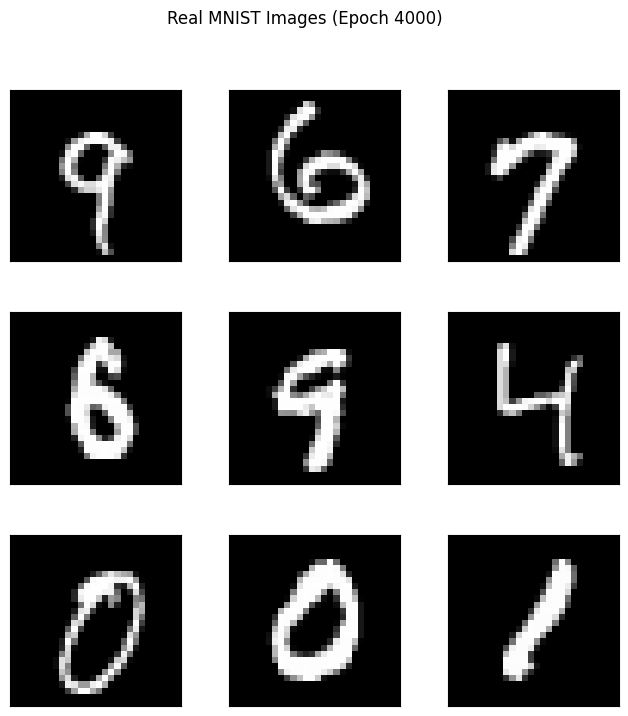

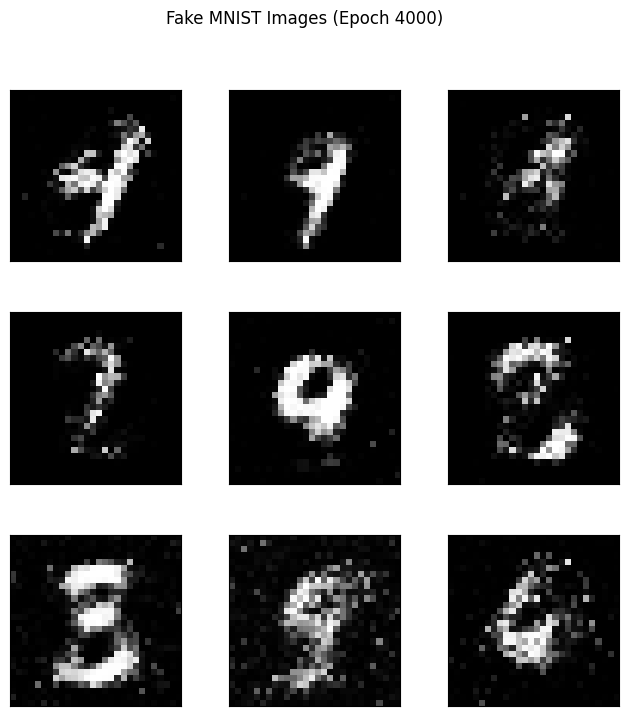

4/4 [==============================] - 0s 5ms/step
Epoch: 6000, Accuracy Real: 84.00%, Accuracy Fake: 83.00%


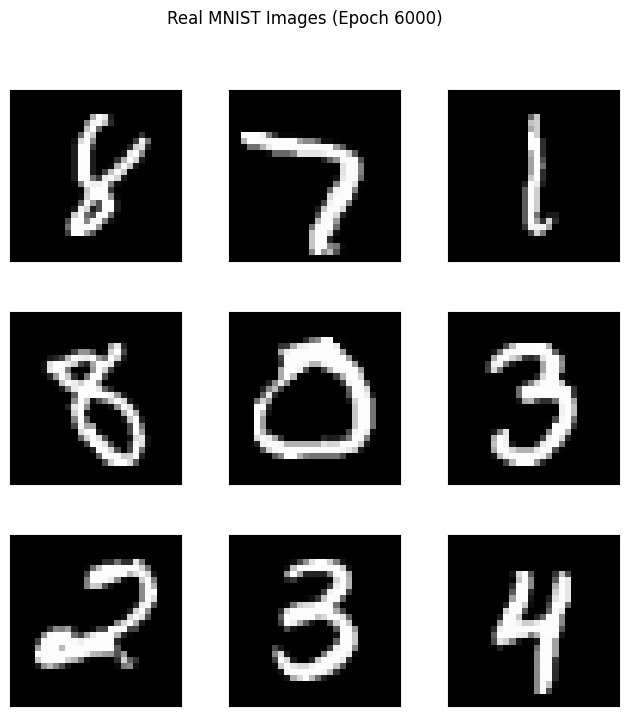

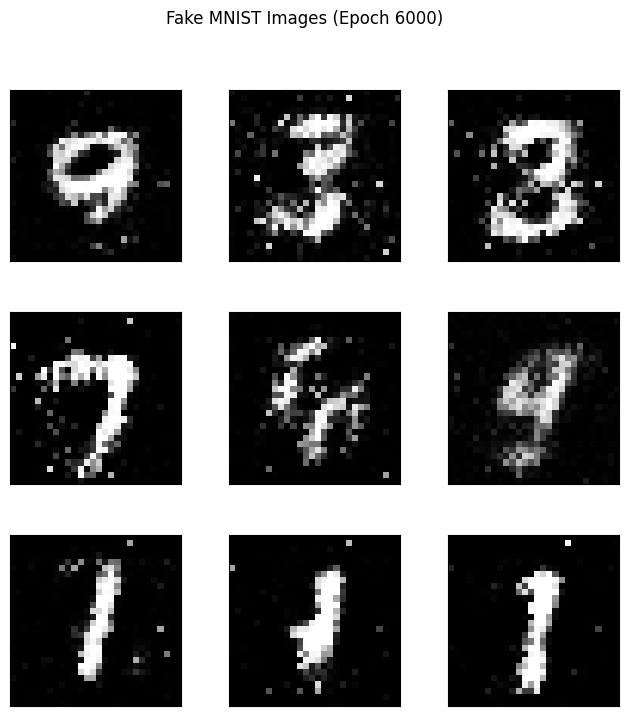

4/4 [==============================] - 0s 5ms/step
Epoch: 8000, Accuracy Real: 89.00%, Accuracy Fake: 84.00%


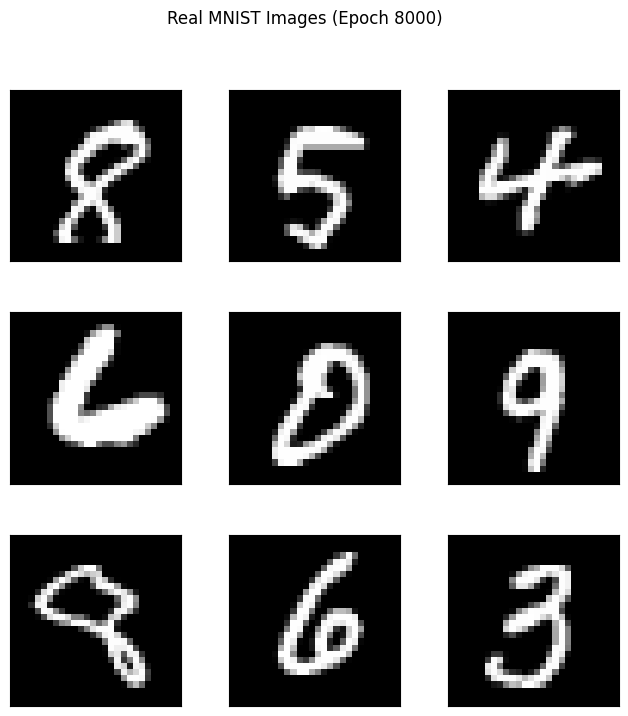

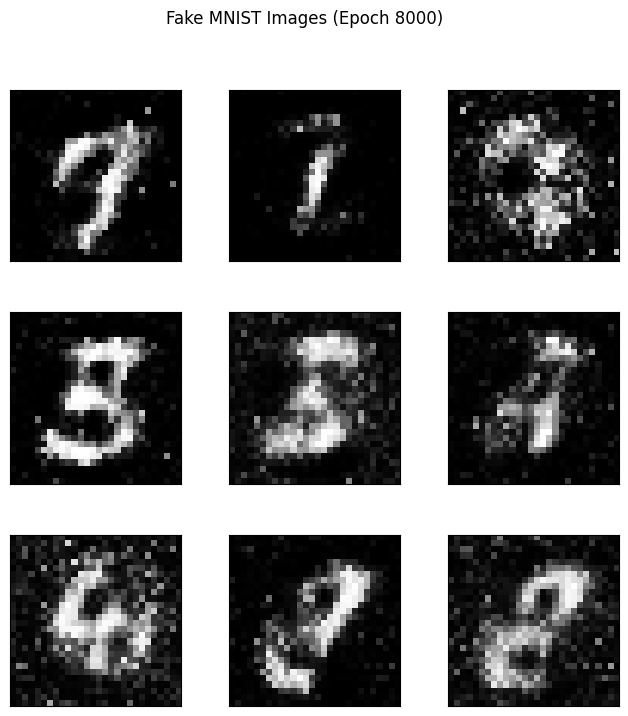

4/4 [==============================] - 0s 4ms/step
Epoch: 10000, Accuracy Real: 94.00%, Accuracy Fake: 83.00%


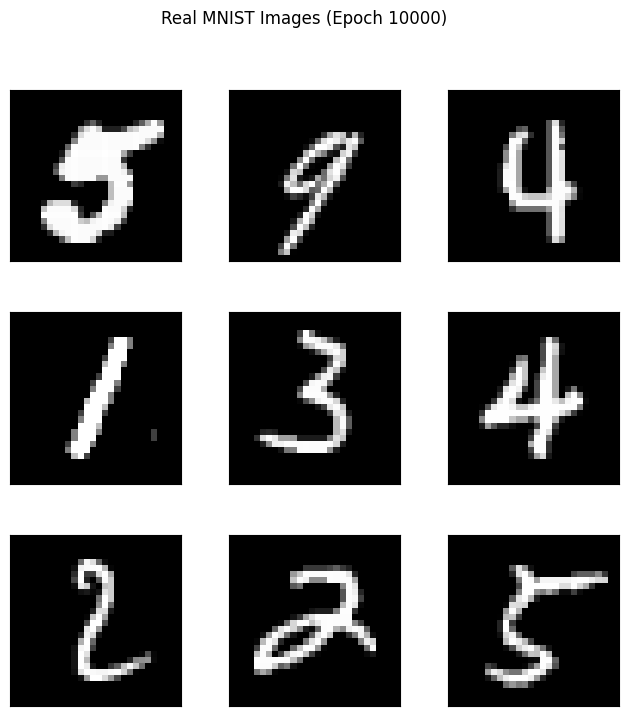

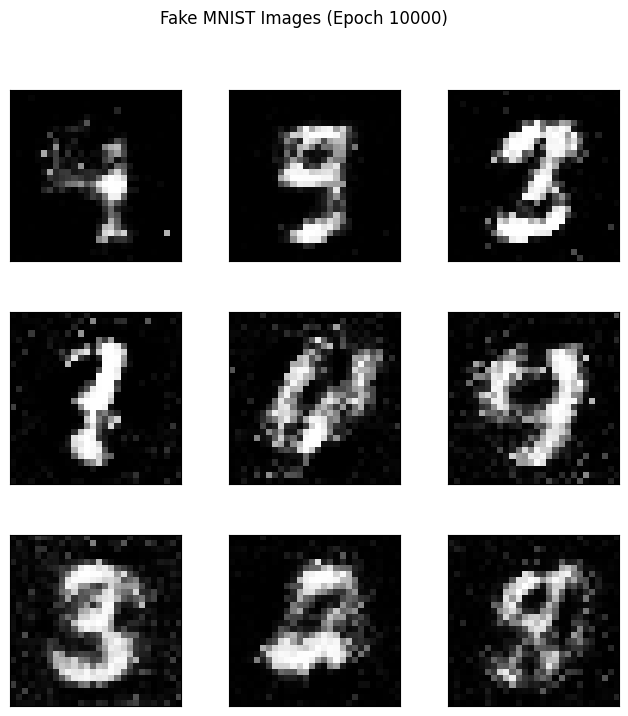

In [ ]:
# Load the MNIST dataset
dataset = load_real_samples()

# Size of the latent space
latent_dim = 100

# Create the discriminator
discriminator = define_discriminator()

# Create the generator
generator = define_generator(latent_dim)

# Create the GAN
gan_model = define_gan(generator, discriminator)

# Train the GAN
train(generator, discriminator, gan_model, latent_dim, dataset)
